# Visualization of Data Preprocessing Pipeline

This is a notebook to visualize if the data preprocessing is doing what it is expected to do.
Also would be useful when generating visuals for our final report.

In [1]:
# allows python file to be immediately loaded upon edit
%load_ext autoreload
%autoreload 2

Imports required for our operations

In [2]:
# monai tools
from monai.utils import first, set_determinism
from monai.transforms import *
from monai.data import CacheDataset, DataLoader, Dataset
# machine learning and viz tools
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
# system and folder access
import os
from glob import glob

/home/mjz-arabica/miniconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading of Dataset

Location of our input data

In [3]:
# NOTE: testing of framework to not split data before hand as it will help with processing 
# and rearanging the dataset without doing folder management
in_dir_images = 'data/nifti_files/images/'
in_dir_labels = 'data/nifti_files/labels/'

# print first image and label for confirmation
print("Checking if data folder are valid...")
print("First image data:", first(glob(in_dir_images + "/*.nii.gz")))
print("First label data:", first(glob(in_dir_labels + "/*.nii.gz")))
print("Folder definition: OK!")

Checking if data folder are valid...
First image data: data/nifti_files/images/liver_115_5.nii.gz
First label data: data/nifti_files/labels/liver_115_5.nii.gz
Folder definition: OK!


Create dataset from our input data which would be used for manipulation

In [4]:
# package files and match inputs with output
image_files = sorted(glob(in_dir_images + "/*.nii.gz")) # sorted by name to ensure match
label_files = sorted(glob(in_dir_labels + "/*.nii.gz"))
# sanity check: ensure names for both files matches
for file_pair in zip(image_files, label_files):
    image_name, label_name = file_pair
    assert(os.path.basename(image_name) == os.path.basename(label_name))
# create dict for volume and segmentation
files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(image_files, label_files)]

# create dataset from files without any additional transforms
raw_dataset = Dataset(data=files, transform=LoadImaged(keys=["vol", "seg"])) # LoadImaged reads nifti file and convert to numpy

Randomly visualize some of the data in the data set

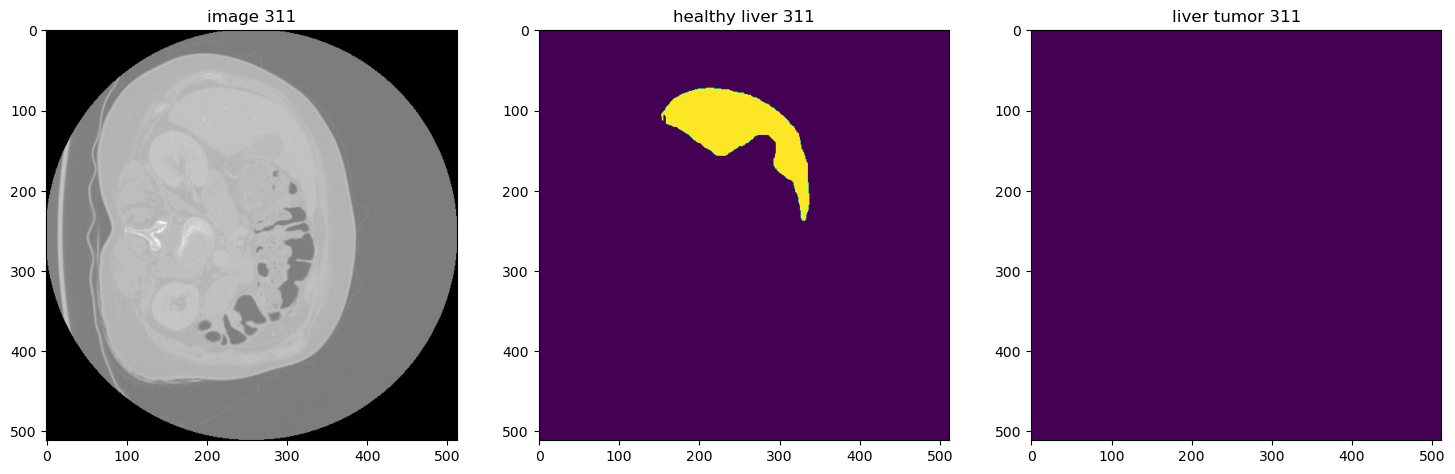

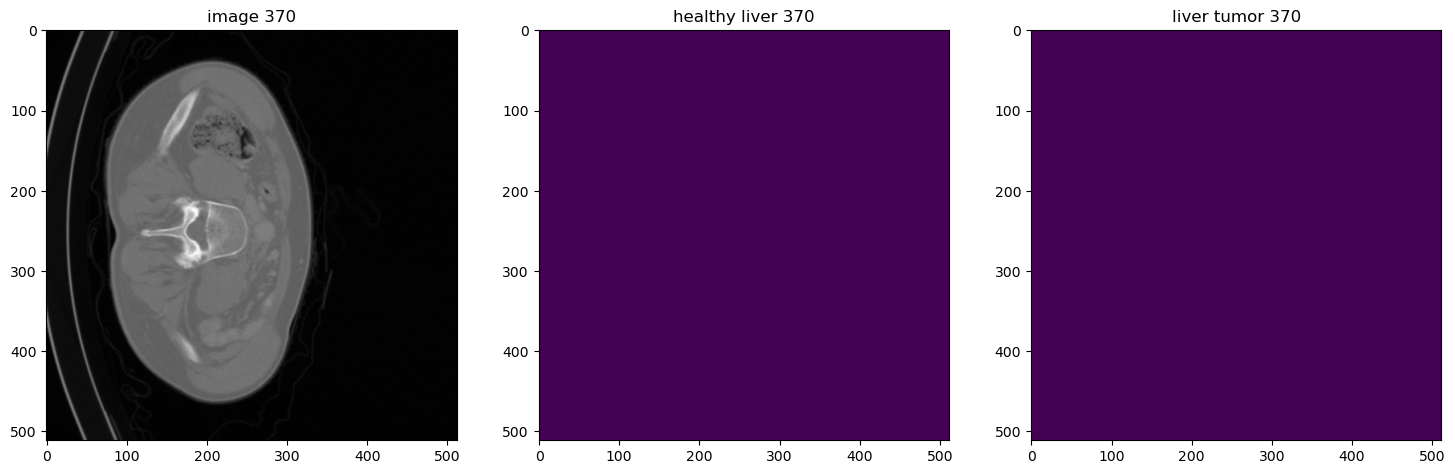

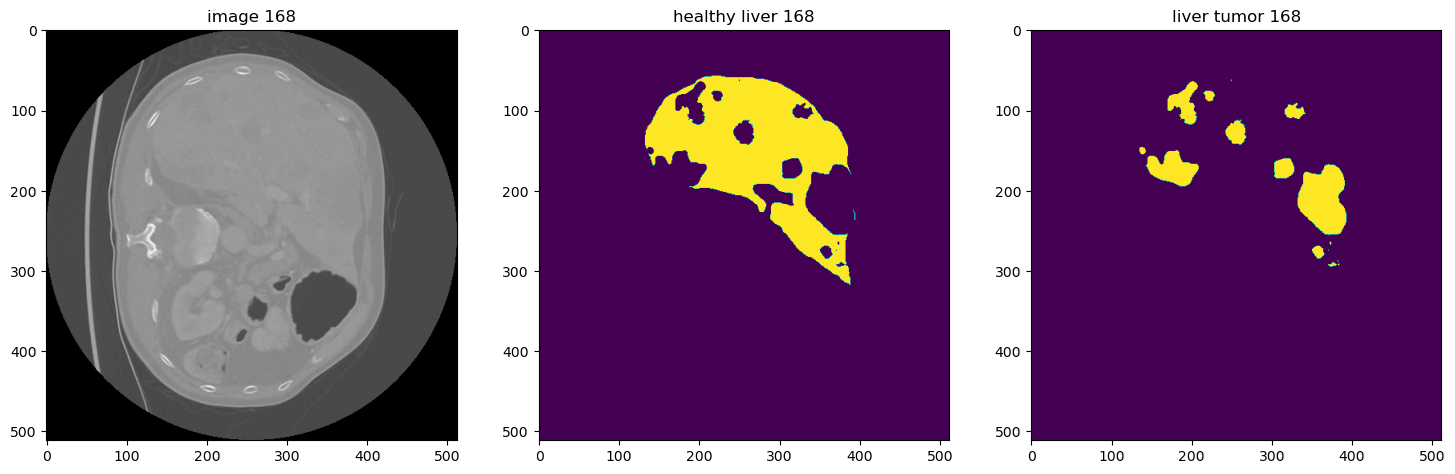

In [5]:
# display properties
num_disp_data = 3
disp_size = 6
# randomly samples data to display, need abit luck of luck to find good samples
inds_to_disp = torch.randint(low=0, high=len(raw_dataset), size=(num_disp_data,))
for i in inds_to_disp:
    plt.figure(f"Data {i}", (disp_size * 3, disp_size))
    plt.subplot(1, 3, 1)
    plt.title(f"image {i}")
    plt.imshow(raw_dataset[i]["vol"][:,:,0], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title(f"healthy liver {i}")
    plt.imshow(raw_dataset[i]["seg"][:,:,0] == 1)
    plt.subplot(1, 3, 3)
    plt.title(f"liver tumor {i}")
    plt.imshow(raw_dataset[i]["seg"][:,:,0] == 2)

## Default Transforms

Let's visualize the default transformation that was provided in the original code to understand what was going on.

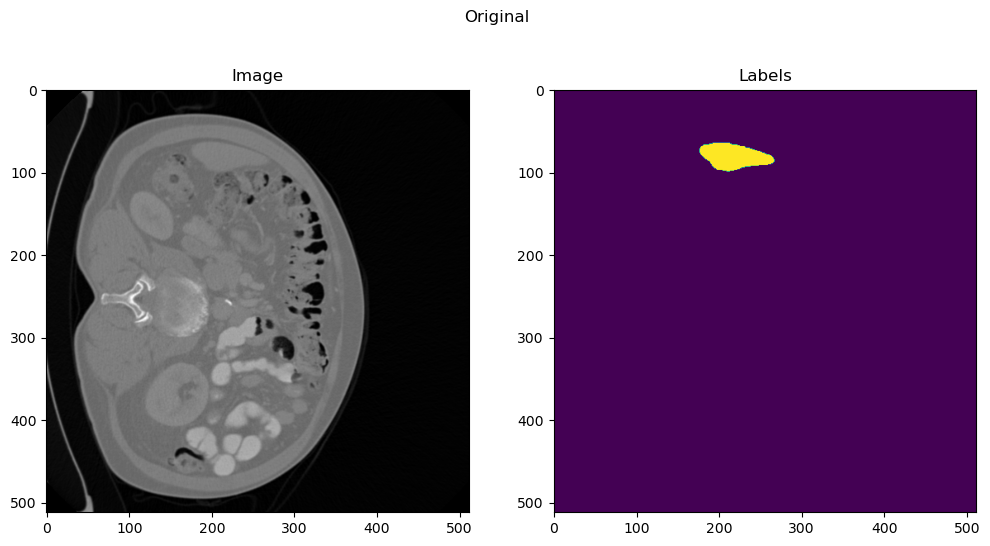

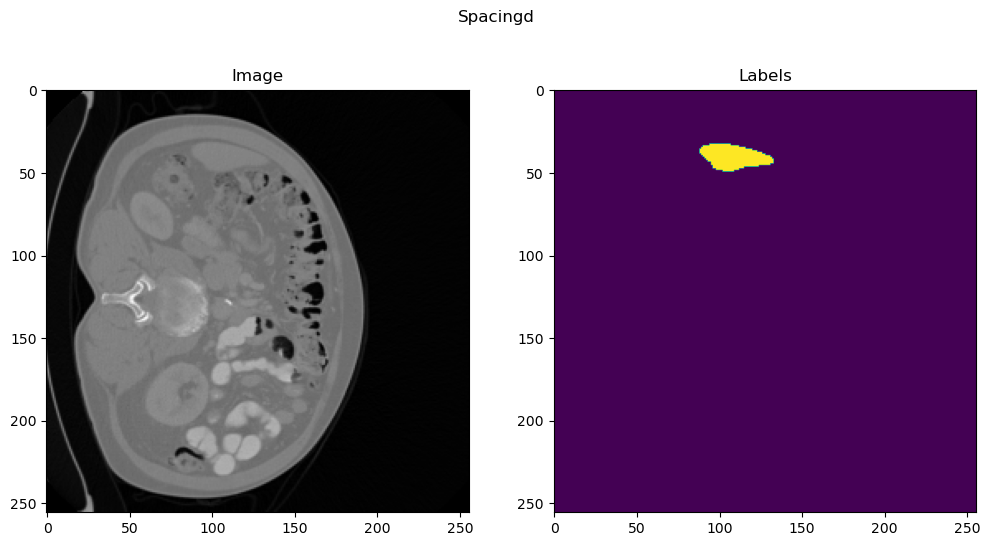

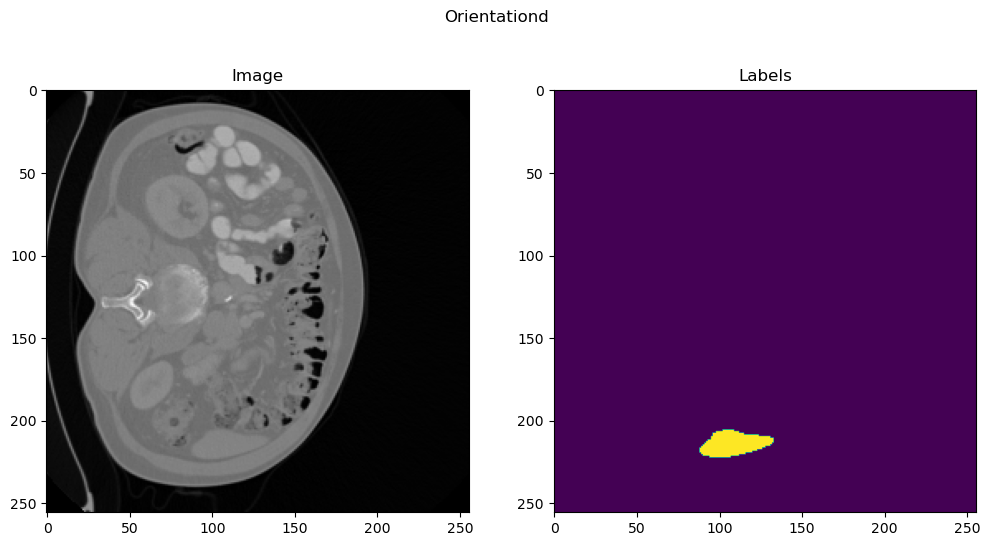

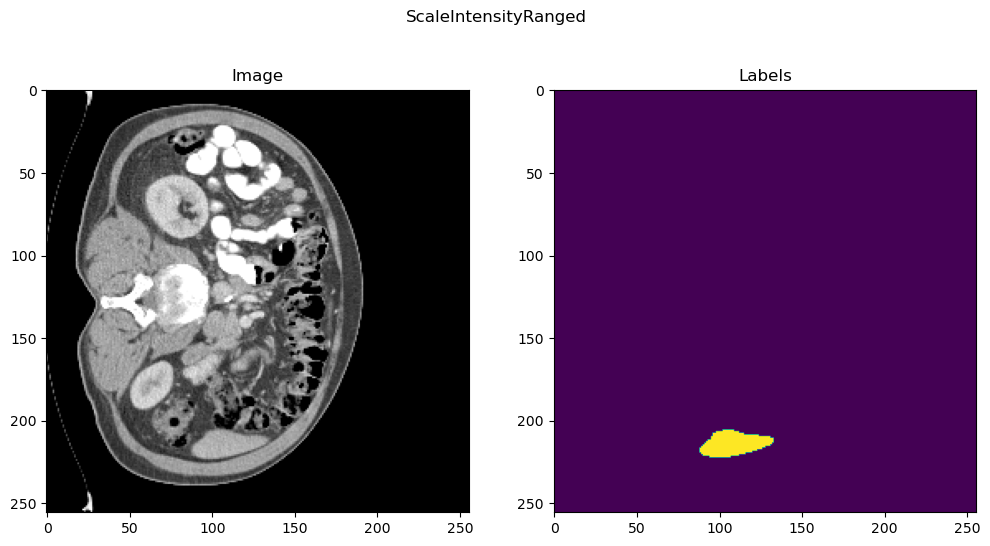

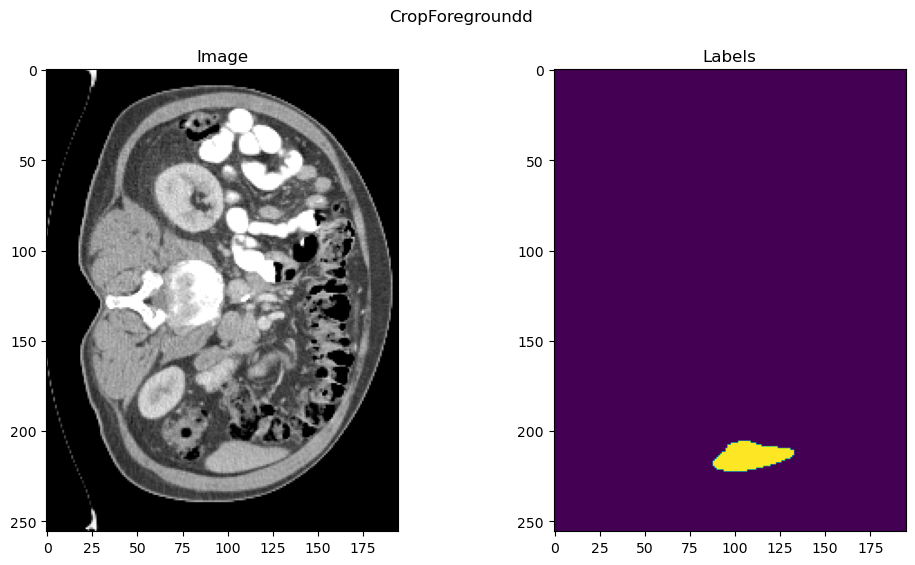

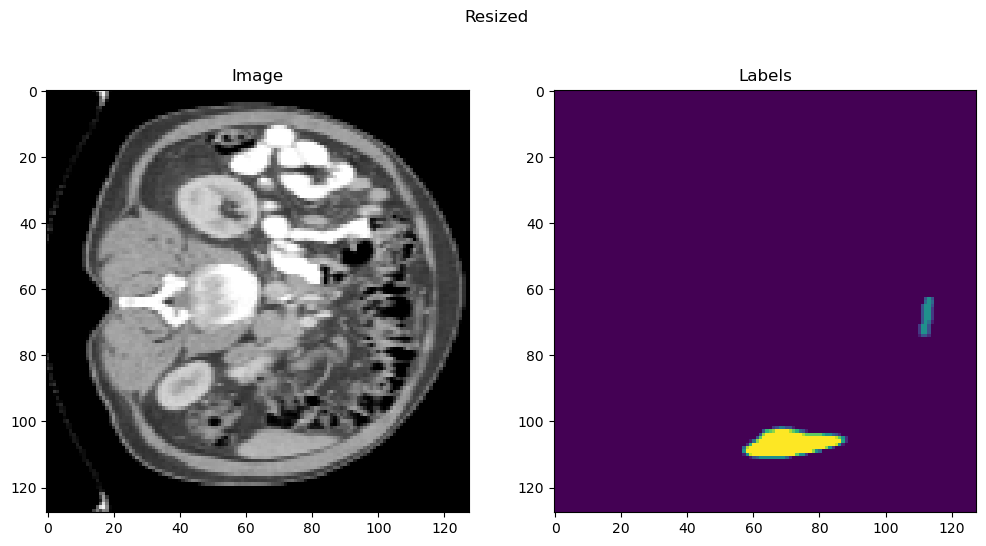

In [10]:
# intermediate transforms we will be visualizing
intermediate_named_transforms = [
    # ("LoadImaged", LoadImaged(keys=["vol", "seg"])), # converts nifti to numpy (won't visualize)
    # ("AddChanneld",AddChanneld(keys=["vol", "seg"])), # adds a channel to the image, basically adds 1 dimension above (won't visualize)
    ("Spacingd", Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest"))), 
    ("Orientationd", Orientationd(keys=["vol", "seg"], axcodes="RAS")),
    ("ScaleIntensityRanged", ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True)), 
    ("CropForegroundd", CropForegroundd(keys=['vol', 'seg'], source_key='vol')),
    ("Resized", Resized(keys=["vol", "seg"], spatial_size=[128,128,64])),   
    # ("ToTensord", ToTensord(keys=["vol", "seg"])), # converts to numpy to tensor for training (won't visualize)
]

# display properties
disp_size = 6
# randomly samples data to display, need abit luck of luck to find good samples
sample_data = raw_dataset[torch.randint(low=0, high=len(raw_dataset), size=(1,))]
# iteratively show each transformation
fig, axs = plt.subplots(1, 2, figsize=(disp_size * 2, disp_size))
fig.suptitle("Original")
axs[0].set_title("Image")
axs[0].imshow(sample_data["vol"][:,:,0], cmap="gray")
axs[1].set_title("Labels")
axs[1].imshow(sample_data["seg"][:,:,0])
sample_data = AddChanneld(keys=["vol", "seg"])(sample_data) # add channel
for xform_name, xform in intermediate_named_transforms:
    sample_data = xform(sample_data)
    fig, axs = plt.subplots(1, 2, figsize=(disp_size * 2, disp_size))
    fig.suptitle(xform_name)
    axs[0].set_title("Image")
    axs[0].imshow(sample_data["vol"][0,:,:,0], cmap="gray")
    axs[1].set_title("Labels")
    axs[1].imshow(sample_data["seg"][0,:,:,0])
plt.show()

## Transforms for UNet 1

Here are the expected additional transforms required for UNet 1 which is supposed to detect both healthy and tumorous liver.

Image: 
- No change

Label: 
- Change segmentation mask to have values 0 for background and 1 for healthy and tumorous liver

In [22]:
default_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True), 
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),   
        ToTensord(keys=["vol", "seg"]),
    ]
)

unet1_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True), 
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),
        ThresholdIntensityd(keys=["seg"], threshold=1, above=False, cval=1),
        ToTensord(keys=["vol", "seg"]),
    ]
)
# note d versus no d, dictionary vs normal non dictionary

default_dataset = Dataset(data=files, transform=default_transforms)
unet1_dataset = Dataset(data=files, transform=unet1_transforms)

Visualize updated segmentation masks to be used as training/testing inputs

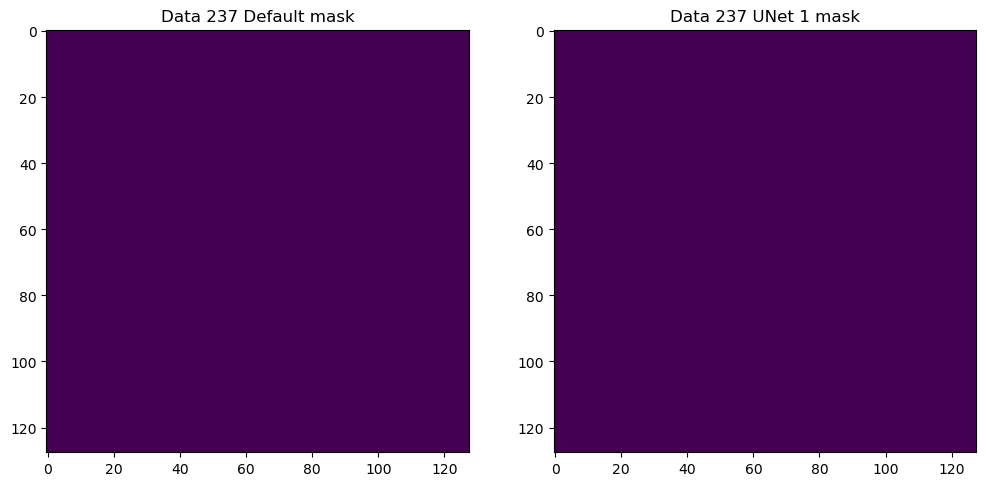

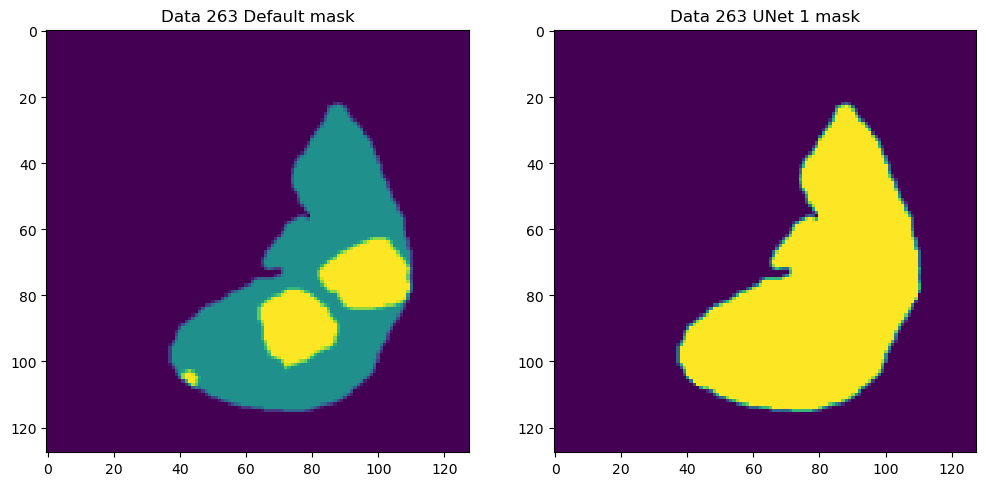

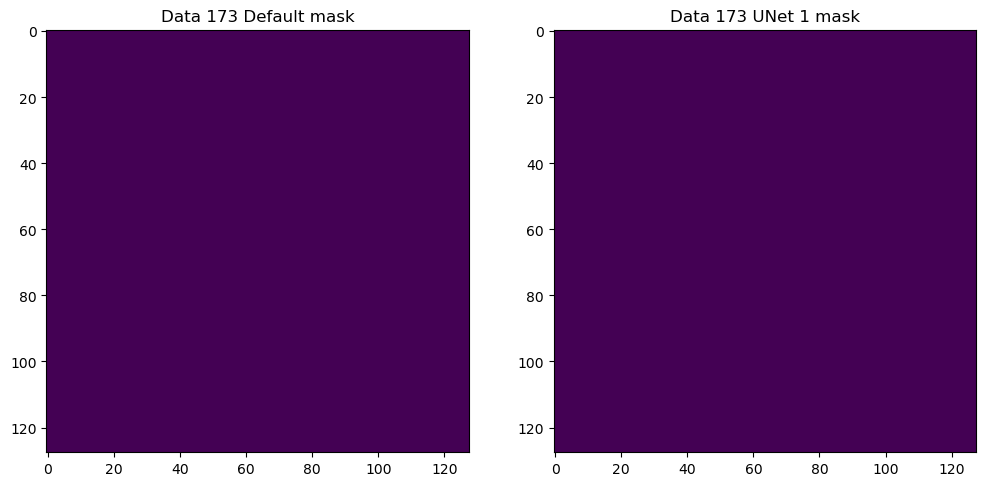

In [26]:
# display properties
num_disp_data = 3
disp_size = 6
# randomly samples data to display, need abit luck of luck to find good samples
inds_to_disp = torch.randint(low=0, high=len(raw_dataset), size=(num_disp_data,))
for i in inds_to_disp:
    plt.figure(f"Data {i}", (disp_size * 2, disp_size))
    plt.subplot(1, 2, 1)
    plt.title(f"Data {i} Default mask")
    plt.imshow(default_dataset[i]["seg"][0,:,:,0])
    plt.subplot(1, 2, 2)
    plt.title(f"Data {i} UNet 1 mask")
    plt.imshow(unet1_dataset[i]["seg"][0,:,:,0])

## Transforms for UNet 2

Here are the expected additional transforms required for UNet 2 which is supposed to detect tumorous liver from liver image only.

Image: 
- Mask non liver portion

Label: 
- Change segmentation mask to have values 0 for background healthy and 1 for tumorous liver

In [37]:
unet2_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True), 
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),
        MaskIntensityd(keys=["vol"], mask_key="seg"),
        ThresholdIntensityd(keys=["seg"], threshold=1, above=True, cval=0),
        ThresholdIntensityd(keys=["seg"], threshold=1, above=False, cval=1),
        ToTensord(keys=["vol", "seg"]),
    ]
)

unet2_dataset = Dataset(data=files, transform=unet2_transforms)

/home/mjz-arabica/miniconda3/envs/ml/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


Visualize updated image and segmentation masks to be used as training/testing inputs

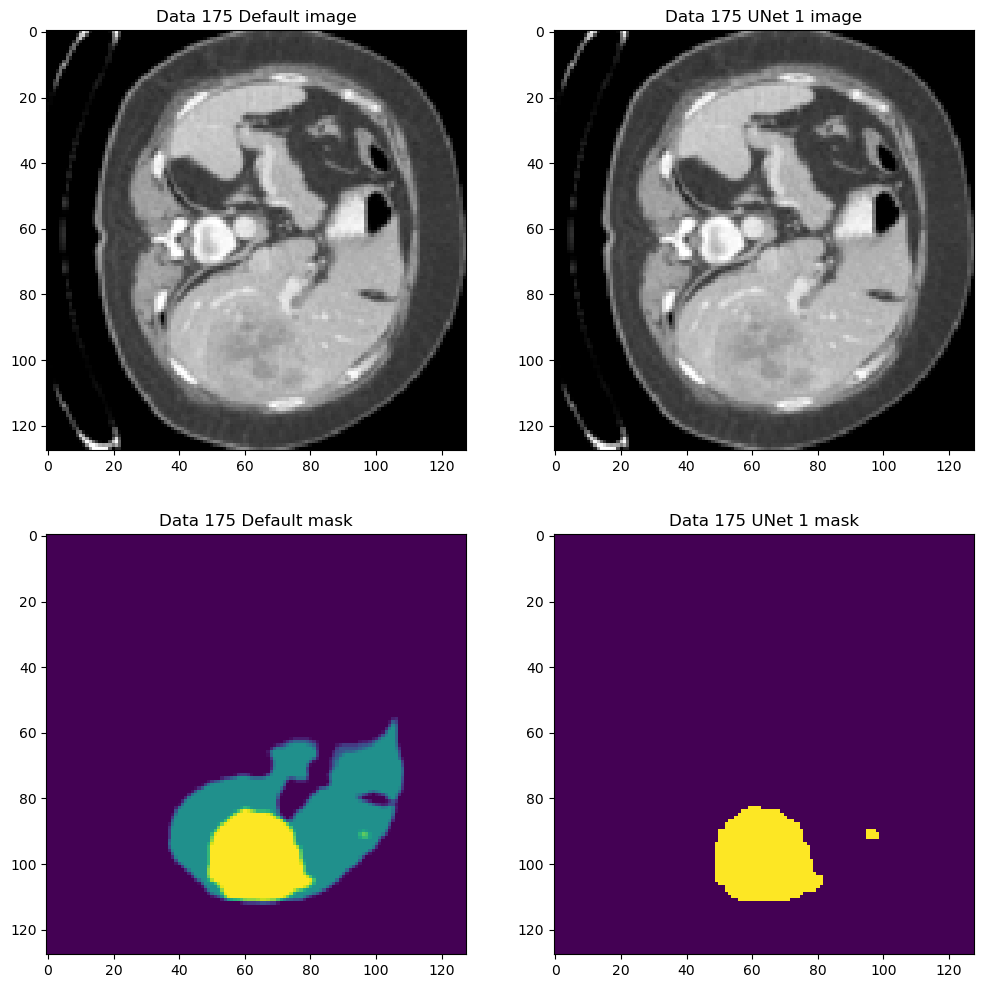

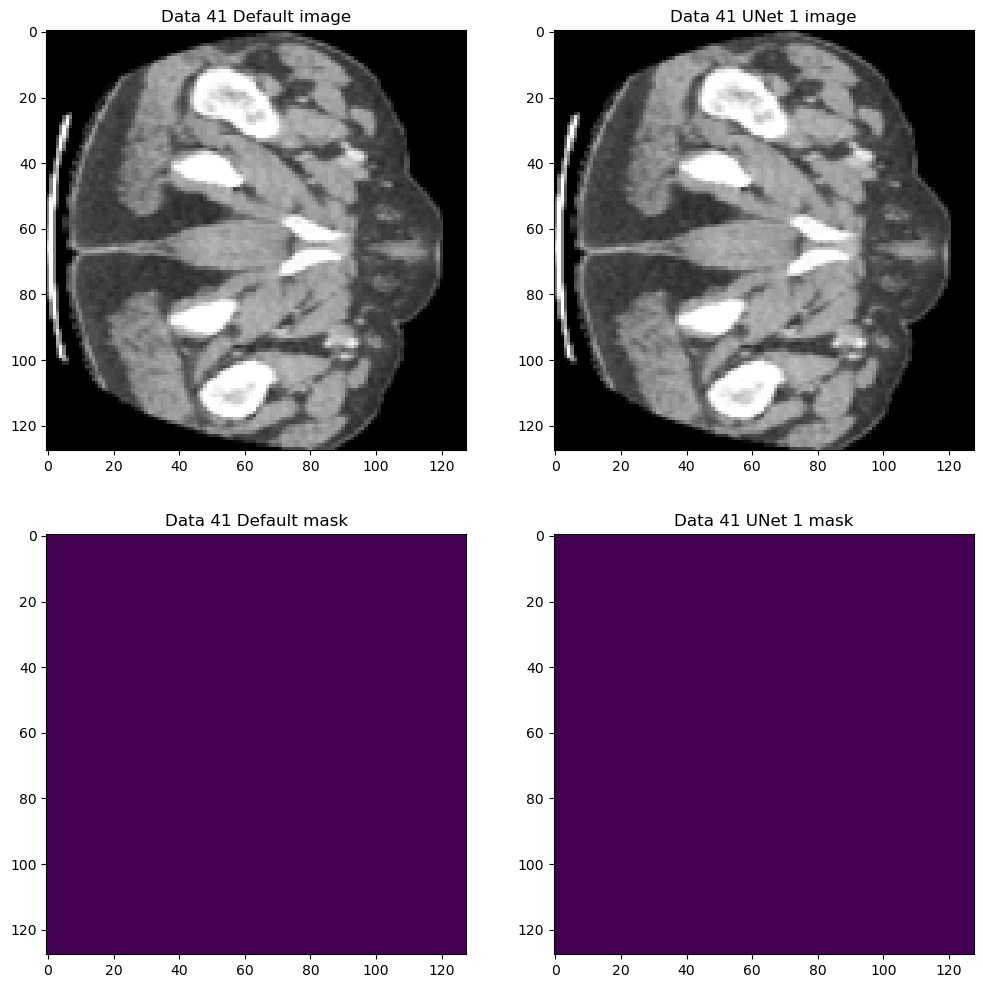

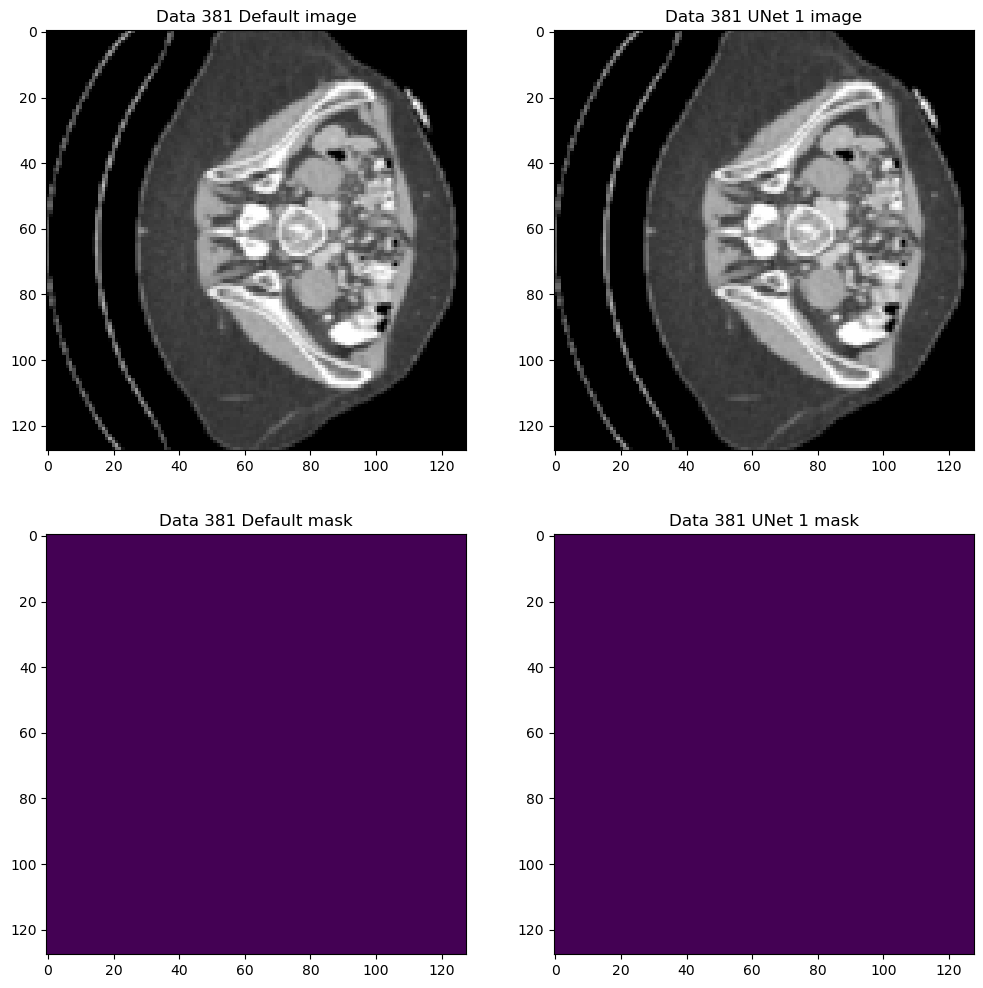

In [40]:
# display properties
num_disp_data = 3
disp_size = 6
# randomly samples data to display, need abit luck of luck to find good samples
inds_to_disp = torch.randint(low=0, high=len(raw_dataset), size=(num_disp_data,))
for i in inds_to_disp:
    plt.figure(f"Data {i}", (disp_size * 2, disp_size * 2))
    plt.subplot(2, 2, 1)
    plt.title(f"Data {i} Default image")
    plt.imshow(default_dataset[i]["vol"][0,:,:,0], cmap='gray')
    plt.subplot(2, 2, 2)
    plt.title(f"Data {i} UNet 1 image")
    plt.imshow(unet2_dataset[i]["vol"][0,:,:,0], cmap='gray')
    plt.subplot(2, 2, 3)
    plt.title(f"Data {i} Default mask")
    plt.imshow(default_dataset[i]["seg"][0,:,:,0])
    plt.subplot(2, 2, 4)
    plt.title(f"Data {i} UNet 1 mask")
    plt.imshow(unet2_dataset[i]["seg"][0,:,:,0])